In [1]:
import hnswlib
import numpy as np
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

In [2]:
from rpy2.robjects import r

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(1000, 1000, 2000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]


Transforming to str index.
... storing 'cells' as categorical
... storing 'batch' as categorical


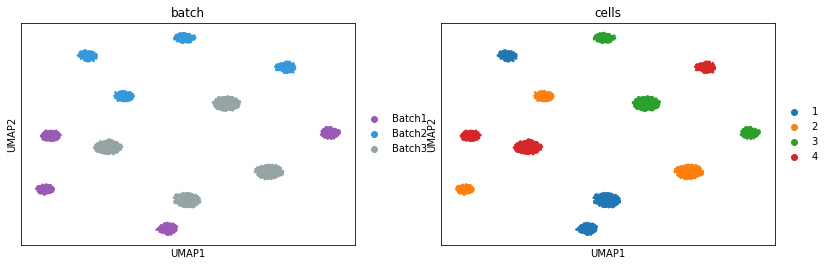

In [6]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
adata.uns["batch_colors"] = ["#9b59b6", "#3498db", "#95a5a6"]
sc.pl.umap(adata,color=['batch','cells'])

In [7]:
from bbtnn.tnn_v3 import *

In [8]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 2, save_on_disk = False, approx = False)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
new function
new function
Processing datasets (0, 2)
new function
new function
Processing datasets (1, 2)
new function
new function
2460 cells defined as MNNs
Calculating KNNs
1540 cells defined as KNNs
Re-format


W0330 14:05:20.930880 16224 deprecation.py:323] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0330 14:05:21.086121 16224 deprecation.py:506] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training neural network
Epoch 1/1000
125/125 - 4s - loss: 1.5515
Epoch 2/1000
125/125 - 2s - loss: 1.1985
Epoch 3/1000
125/125 - 2s - loss: 1.0337
Epoch 4/1000
125/125 - 2s - loss: 0.8469
Epoch 5/1000
125/125 - 2s - loss: 0.7354
Epoch 6/1000
125/125 - 2s - loss: 0.6484
Epoch 7/1000
125/125 - 2s - loss: 0.5813
Epoch 8/1000
125/125 - 2s - loss: 0.5038
Epoch 9/1000
125/125 - 2s - loss: 0.4476
Epoch 10/1000
125/125 - 2s - loss: 0.4144
Epoch 11/1000
125/125 - 2s - loss: 0.4272
Epoch 12/1000
125/125 - 2s - loss: 0.3945
Epoch 13/1000
125/125 - 2s - loss: 0.3785
Epoch 14/1000
125/125 - 2s - loss: 0.3832
Epoch 15/1000
125/125 - 2s - loss: 0.3862
4000/4000 - 0s
Wall time: 34.7 s


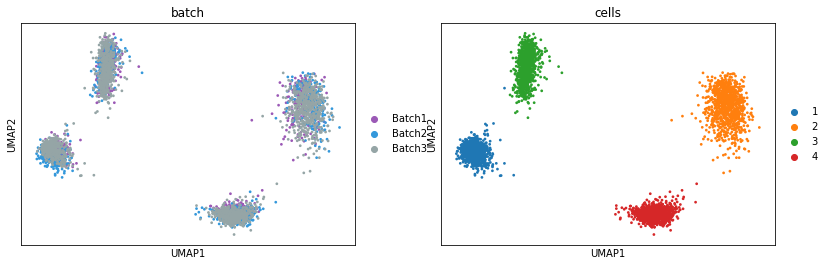

In [9]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [10]:
%%time
dim = 50
num_elements = 1000000

# Generating sample data
data = np.float32(np.random.random((num_elements, dim)))

# Declaring index
p = hnswlib.Index(space='l2', dim=dim)  # possible options are l2, cosine or ip

# Initing index
# max_elements - the maximum number of elements (capacity). Will throw an exception if exceeded
# during insertion of an element.
# The capacity can be increased by saving/loading the index, see below.
#
# ef_construction - controls index search speed/build speed tradeoff
#
# M - is tightly connected with internal dimensionality of the data. Strongly affects the memory consumption (~M)
# Higher M leads to higher accuracy/run_time at fixed ef/efConstruction

p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(10)
p.set_num_threads(4)
p.add_items(data)

# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(data, k=50)

Wall time: 7min 53s


In [11]:
def nn(ds1, ds2, names1, names2, knn=50):
    print("new function")
    dim = ds1.shape[1]
    num_elements = ds1.shape[0]
    p = hnswlib.Index(space='l2', dim=dim)
    p.init_index(max_elements=num_elements, ef_construction=100, M=16)
    p.set_ef(10)
    p.add_items(ds1)
    ind, distances = p.knn_query(ds2, k=knn)
    
    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((names1[a], names2[b_i]))
    
    return(match)